## VARMA Model

VARMA Model is simply Vector with ARMA Model. That is to say, we have seen that VAR model deals with the $K$ dimensional equations.

We're goig to see user of VARMA model in the datasets we used for VAR mdoel. We'll see that this VARMA model performs poorly on these datasets. This is because the corelation between these two timeseries is not enough. So the ideal situation is we first user ARIMA model on single timeseries to see the model performance.

In [4]:
import pandas as pd
import numpy as np

from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse

Loading the datasets. Here these two datasets have interdependent timeseries.

**Step 1 : Loading the Datasets**

In [2]:
df = pd.read_csv(r'C:\Users\nevishwakarma\Documents\Datasets\Data_Udemy\M2SLMoneyStock.csv', index_col=[0], parse_dates=True)
df.index.freq = 'MS'
df.head()

,Money
Date,
1995-01-01,3492.4
1995-02-01,3489.9
1995-03-01,3491.1
1995-04-01,3499.2
1995-05-01,3524.2


In [3]:
sp = pd.read_csv(r'C:\Users\nevishwakarma\Documents\Datasets\Data_Udemy\PCEPersonalSpending.csv', index_col=[0], parse_dates=True)
sp.index.freq = 'MS'
sp.head()

,Spending
Date,
1995-01-01,4851.2
1995-02-01,4850.8
1995-03-01,4885.4
1995-04-01,4890.2
1995-05-01,4933.1


In [5]:
df = df.join(sp)

In [6]:
df = df.dropna()
df.head()

,Money,Spending
Date,,
1995-01-01,3492.4,4851.2
1995-02-01,3489.9,4850.8
1995-03-01,3491.1,4885.4
1995-04-01,3499.2,4890.2
1995-05-01,3524.2,4933.1


<AxesSubplot:xlabel='Date'>

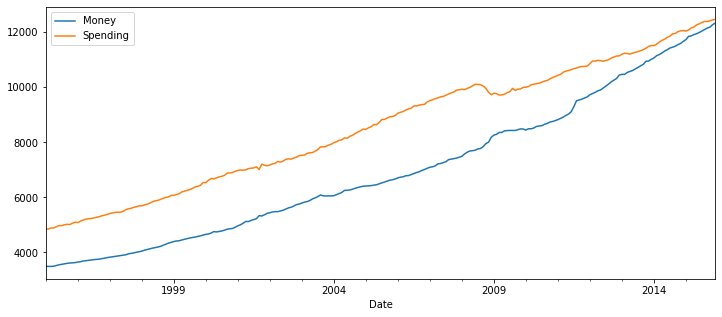

In [7]:
df.plot(figsize=(12,5))

**Step 2 : Checking for stationarity**

In [8]:
def parse_results(results):
    if results[1] <= 0.05:
        print("Time-series is Stationary")
    else:
        print("Time-series is Non-Stationary")

result1 = adfuller(df['Money'])
parse_results(result1)

Time-series is Non-Stationary


In [9]:
result1 = adfuller(df['Spending'])
parse_results(result1)

Time-series is Non-Stationary


So, both the series are non-stationary

**Step 3 : Making Series Stationary**

In [10]:
df_transformed = df.diff()
df_transformed = df_transformed.dropna()

In [11]:
parse_results(adfuller(df_transformed['Money']))

Time-series is Non-Stationary


In [12]:
parse_results(adfuller(df_transformed['Spending']))

Time-series is Stationary


Since Money is still non-stationary we have to run diff on both the columns.

In [13]:
df_transformed = df_transformed.diff().dropna()

In [14]:
parse_results(adfuller(df_transformed['Money']))

Time-series is Stationary


In [15]:
parse_results(adfuller(df_transformed['Spending']))

Time-series is Stationary


Cool, now both the series are stationary.

**Step 4 : Train Test split**

In [16]:
nobs = 12
train = df_transformed[:-nobs] # start = begining of DF --> -12 from the end | We get 250-12 data points in train set
test = df_transformed[-nobs:] # start = Start at -12 -> end of the dataframe | We get 12 data points in test set

**Step 5 : Choosing the order of p & q value using <tt>auto_arima</tt>**

In [17]:
from pmdarima import auto_arima

In [18]:
auto_arima(df['Money'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 2, 1), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [19]:
auto_arima(df['Spending'], maxiter=1000)

ARIMA(maxiter=1000, order=(1, 1, 2), scoring_args={}, suppress_warnings=True)

The $I$ terms in both Money and Spending is 2 and 1 repectively. That means the Money series will have to be differenced twice to make it stationary and Spending series will have to be differenced once. This is what we've seen previously, in the above steps. So we're going to use VARMA(1,2).

**Step 6 : Modelling**

In [20]:
model = VARMAX(train, order=(1,2), trend='c')
results = model.fit(maxiter=1000, disp=False)
results.summary()

C:\Users\nevishwakarma\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'


Dep. Variable:,"['Money', 'Spending']",No. Observations:,238
Model:,"VARMA(1,2)",Log Likelihood,-2286.019
,+ intercept,AIC,4606.039
Date:,"Fri, 31 Dec 2021",BIC,4665.067
Time:,00:59:18,HQIC,4629.828
Sample:,03-01-1995,,
,- 12-01-2014,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.55, 0.00",Jarque-Bera (JB):,"552.42, 121.95"
Prob(Q):,"0.46, 0.97",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"5.59, 2.90",Skew:,"1.33, -0.34"


**Step 7 : Prediction for Testing**

In [21]:
df_predictions = results.forecast(12)
df_predictions.head()

,Money,Spending
2015-01-01,-11.955355,38.304043
2015-02-01,-11.256512,-5.078215
2015-03-01,1.302755,-0.005363
2015-04-01,-1.638995,-0.392828
2015-05-01,0.987741,0.366241


Above values are the second order diff so we need to revert the diff process twice to get the original data back

In [23]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_predictions['Money_1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + df_predictions['Money'].cumsum()

# Now build the forecast values from the first difference set
df_predictions['MoneyForecast'] = df['Money'].iloc[-nobs-1] + df_predictions['Money'].cumsum()

In [24]:
# Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
df_predictions['Spending_1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + df_predictions['Spending'].cumsum()

# Now build the forecast values from the first difference set
df_predictions['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + df_predictions['Spending'].cumsum()

In [25]:
df_predictions

,Money,Spending,Money_1d,MoneyForecast,Spending_1d,SpendingForecast
2015-01-01,-11.955355,38.304043,66.644645,11658.144645,48.904043,12100.304043
2015-02-01,-11.256512,-5.078215,55.388133,11646.888133,43.825827,12095.225827
2015-03-01,1.302755,-0.005363,56.690888,11648.190888,43.820465,12095.220465
2015-04-01,-1.638995,-0.392828,55.051893,11646.551893,43.427637,12094.827637
2015-05-01,0.987741,0.366241,56.039633,11647.539633,43.793878,12095.193878


In [36]:
pd.concat([df.iloc[-12:], df_predictions[['MoneyForecast','SpendingForecast']]], axis=1)

,Money,Spending,MoneyForecast,SpendingForecast
2015-01-01,11733.2,12046.0,11658.144645,12100.304043
2015-02-01,11852.4,12082.4,11646.888133,12095.225827
2015-03-01,11868.8,12158.3,11648.190888,12095.220465
2015-04-01,11916.1,12193.8,11646.551893,12094.827637
2015-05-01,11947.6,12268.1,11647.539633,12095.193878
2015-06-01,11993.1,12308.3,11647.181550,12095.227108
2015-07-01,12045.3,12355.4,11647.648285,12095.477615
2015-08-01,12096.8,12394.0,11647.641415,12095.605963
2015-09-01,12153.8,12392.8,11647.912776,12095.806624
2015-10-01,12187.7,12416.1,11648.022007,12095.965259


<AxesSubplot:xlabel='Date'>

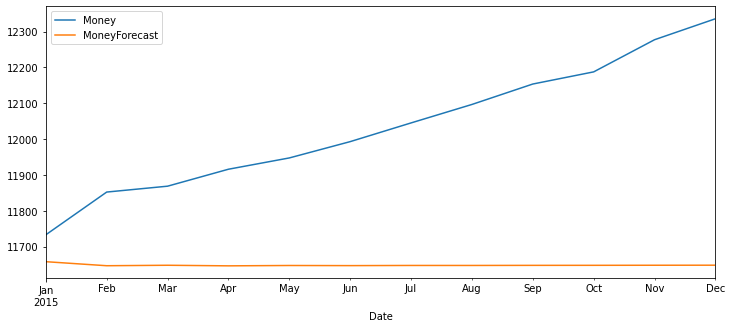

In [37]:
df['Money'][-nobs:].plot(figsize=(12,5), legend=True)
df_predictions['MoneyForecast'].plot(legend=True)

<AxesSubplot:xlabel='Date'>

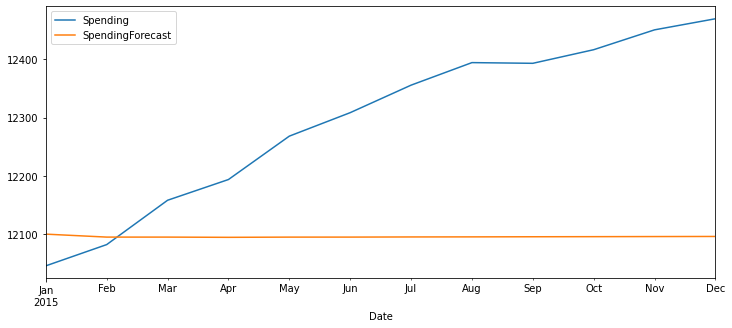

In [38]:
df['Spending'][-nobs:].plot(figsize=(12,5), legend=True)
df_predictions['SpendingForecast'].plot(legend=True)

As we see, the VARMA model is performing worse than VAR model.

In [40]:
rmse1 = rmse(df['Money'][-nobs:],df_predictions['MoneyForecast'])
rmse1

423.7220372936778

In [41]:
rmse2 = rmse(df['Spending'][-nobs:],df_predictions['SpendingForecast'])
rmse2

242.16439361640198

Clearly these results are less accurate than our earlier VAR(5) model. Still, this tells us something!
## Let's compare these results to individual ARMA(1,2) models

In [42]:
from statsmodels.tsa.arima_model import ARMA,ARMAResults

## Money

In [43]:
model = ARMA(train['Money'],order=(1,2))
results = model.fit()
results.summary()

C:\Users\nevishwakarma\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Money   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1117.710
Method:                       css-mle   S.D. of innovations             26.215
Date:                Fri, 31 Dec 2021   AIC                           2245.421
Time:                        01:09:19   BIC                           2262.782
Sample:                    03-01-1995   HQIC                          2252.418
                         - 12-01-2014                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.1814      0.029      6.302      0.000       0.125       0.238
ar.L1.Money    -0.3569      0.293     -1.217      0.223      -0.931       0.218
ma.L1.Money    -0.4087      0.260     -1.572      0.116      -0.918       0.101
ma.L2.Money    -0.5912      0.260     -2.278      0.023      -1.100      -0.083
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.8023           +0.0000j            2.8023            0.5000
MA.1            1.0000           +0.0000j            1.0000            0.0000
MA.2           -1.6913           +0.0000j            1.6913            0.5000
-----------------------------------------------------------------------------
"""

In [44]:
start=len(train)
end=len(train)+len(test)-1
z1 = results.predict(start=start, end=end).rename('Money')
z1 = pd.DataFrame(z1)
z1

,Money
2015-01-01,-14.498971
2015-02-01,-10.946915
2015-03-01,4.152537
2015-04-01,-1.235707
2015-05-01,0.687090
2015-06-01,0.000939
2015-07-01,0.245792
2015-08-01,0.158416
2015-09-01,0.189596
2015-10-01,0.178470


**Invert the Transformation, Evaluate the Forecast**

In [45]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z1['Money1d'] = (df['Money'].iloc[-nobs-1]-df['Money'].iloc[-nobs-2]) + z1['Money'].cumsum()

# Now build the forecast values from the first difference set
z1['MoneyForecast'] = df['Money'].iloc[-nobs-1] + z1['Money1d'].cumsum()

z1

,Money,Money1d,MoneyForecast
2015-01-01,-14.498971,64.101029,11734.201029
2015-02-01,-10.946915,53.154114,11787.355142
2015-03-01,4.152537,57.306651,11844.661793
2015-04-01,-1.235707,56.070944,11900.732737
2015-05-01,0.687090,56.758034,11957.490771
2015-06-01,0.000939,56.758973,12014.249744
2015-07-01,0.245792,57.004765,12071.254510
2015-08-01,0.158416,57.163182,12128.417691
2015-09-01,0.189596,57.352778,12185.770469
2015-10-01,0.178470,57.531248,12243.301717


In [47]:
RMSE3 = rmse(df['Money'][-nobs:], z1['MoneyForecast'])

print(f'Money VARMA(1,2) RMSE: {rmse1:.3f}')
print(f'Money  ARMA(1,2) RMSE: {RMSE3:.3f}')

Money VARMA(1,2) RMSE: 423.722
Money  ARMA(1,2) RMSE: 32.236


## Personal Spending

In [48]:
model = ARMA(train['Spending'],order=(1,2))
results = model.fit()
results.summary()

C:\Users\nevishwakarma\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               Spending   No. Observations:                  238
Model:                     ARMA(1, 2)   Log Likelihood               -1182.411
Method:                       css-mle   S.D. of innovations             34.661
Date:                Fri, 31 Dec 2021   AIC                           2374.823
Time:                        01:10:41   BIC                           2392.184
Sample:                    03-01-1995   HQIC                          2381.820
                         - 12-01-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0856      0.245      0.350      0.726      -0.394       0.565
ar.L1.Spending    -0.3403      0.511     -0.666      0.505      -1.342       0.661
ma.L1.Spending    -0.6451      0.521     -1.237      0.216      -1.667       0.377
ma.L2.Spending    -0.2139      0.485     -0.441      0.659      -1.165       0.737
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -2.9388           +0.0000j            2.9388            0.5000
MA.1            1.1281           +0.0000j            1.1281            0.0000
MA.2           -4.1439           +0.0000j            4.1439            0.5000
-----------------------------------------------------------------------------
"""

In [49]:
start=len(train)
end=len(train)+len(test)-1
z2 = results.predict(start=start, end=end).rename('Spending')
z2 = pd.DataFrame(z2)
z2

,Spending
2015-01-01,33.555855
2015-02-01,-3.338259
2015-03-01,1.250695
2015-04-01,-0.310824
2015-05-01,0.220526
2015-06-01,0.039719
2015-07-01,0.101244
2015-08-01,0.080309
2015-09-01,0.087432
2015-10-01,0.085008


**Invert the Transformation, Evaluate the Forecast**

In [51]:
# Add the most recent first difference from the training set to the forecast cumulative sum
z2['Spending1d'] = (df['Spending'].iloc[-nobs-1]-df['Spending'].iloc[-nobs-2]) + z2['Spending'].cumsum()

# Now build the forecast values from the first difference set
z2['SpendingForecast'] = df['Spending'].iloc[-nobs-1] + z2['Spending1d'].cumsum()

z2

,Spending,Spending1d,SpendingForecast
2015-01-01,33.555855,44.155855,12106.155855
2015-02-01,-3.338259,40.817596,12146.973450
2015-03-01,1.250695,42.068291,12189.041741
2015-04-01,-0.310824,41.757467,12230.799208
2015-05-01,0.220526,41.977993,12272.777201
2015-06-01,0.039719,42.017712,12314.794913
2015-07-01,0.101244,42.118956,12356.913869
2015-08-01,0.080309,42.199265,12399.113134
2015-09-01,0.087432,42.286697,12441.399831
2015-10-01,0.085008,42.371705,12483.771537


In [52]:
RMSE4 = rmse(df['Spending'][-nobs:], z2['SpendingForecast'])

print(f'Spending VARMA(1,2) RMSE: {rmse2:.3f}')
print(f'Spending  ARMA(1,2) RMSE: {RMSE4:.3f}')

Spending VARMA(1,2) RMSE: 242.164
Spending  ARMA(1,2) RMSE: 52.334


<strong>CONCLUSION:</strong> It looks like the VARMA(1,2) model did a relatively poor job compared to simpler alternatives. This tells us that there is little or no interdepence between Money Stock and Personal Consumption Expenditures, at least for the timespan we investigated. This is helpful! By fitting a model and getting poor results we know more about the data than we did before.